# Equation of motion

In [238]:
from sympy import *
import numpy as np
import cloudpickle

from scipy.integrate import odeint, ode
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from utils import swing_animation

In [2]:
# init_printing()

In [3]:
# macro
frac = Rational

In [4]:
# unit vector
i = Matrix([1, 0])
j = Matrix([0, 1])

In [5]:
join = lambda l: Matrix([x for s in l for x in s])

In [6]:
q = Matrix(var('q1:4'))
dq = Matrix(var('dq1:4'))
ddq= Matrix(var('ddq1:4'))

z = q.col_join(dq)
dz= dq.col_join(ddq)

u = Matrix(var('u1:3'))

m = Matrix(var('m1:4'))
I = Matrix(var('I1:4'))
l = Matrix(var('l0:4'))
lc = Matrix(var('lc1:4'))
d = Matrix(var('d1_2:4'))
g = var('g')
constraints = Matrix(var('k c w q_max'))
parameters = join([m, I, l, lc, d, [g]])
# parameters = m.col_join(I).col_join(l).col_join(lc).col_join(d).col_join(Matrix([g]))

In [7]:
e0 = cos(q1) * (-j) + sin(q1) * (-i)
e1 = cos(q1) * (-i) + sin(q1) * ( j)
e2 = cos(q1+q2) * (-j) + sin(q1+q2) * (-i) 
e3 = cos(q1+q3) * ( j) + sin(q1+q3) * ( i)

In [8]:
# position of joints
p1 = l0 * e0
p2 = p1 + d1_2 *  e1
p3 = p1 + d1_3 *(-e1)
p21= p2 + l2 * e2
p31= p3 + l3 * e3

In [9]:
# postion of mass center
pc1 = p1 + (d1_2-lc1) * e1
pc2 = p2 + lc2 * e2
pc3 = p3 + lc3 * e3

pc = pc1.row_join(pc2).row_join(pc3)

In [10]:
# mass center velocity
dpc1 = pc1.jacobian(z) * dz
dpc2 = pc2.jacobian(z) * dz
dpc3 = pc3.jacobian(z) * dz

dpc = dpc1.row_join(dpc2).row_join(dpc3)

In [11]:
# Energy
T1 = simplify(frac(1, 2) * I1 * dq1 * dq1     + frac(1, 2) * m1 * dpc1.dot(dpc1))
T2 = simplify(frac(1, 2) * I2 *(dq1 + dq2)**2 + frac(1, 2) * m2 * dpc2.dot(dpc2))
T3 = simplify(frac(1, 2) * I3 *(dq1 + dq3)**2 + frac(1, 2) * m3 * dpc3.dot(dpc3))
T = Matrix([T1 + T2 + T3])

In [12]:
U = Matrix([m1 * g * pc1[1] + m2 * g * pc2[1] + m3 * g * pc3[1]])

In [14]:
tmp = T.jacobian(dq)
H = tmp.jacobian(dq)
C = tmp.jacobian(q) * dq - T.jacobian(q).T
G = U.jacobian(q).T

In [15]:
# two actuator
B = Matrix(np.vstack([np.zeros(2), np.eye(2)]))

In [16]:
ddq = H.LUsolve(-C - G + B * u)
# ddq = H.inv() * (-C - G - B * u)
# Don't do that. The computation expense is much higher by a few level!!!!!!!!!!
ddq_free = H.LUsolve(B * u)

In [17]:
ddq_np = lambdify([z, u, parameters], ddq, 'numpy')

In [ ]:
# parameters.T

In [18]:
# kinematics
p1_np = lambdify([z, parameters], p1)
p2_np = lambdify([z, parameters], p2)
p3_np = lambdify([z, parameters], p3)
p21_np = lambdify([z, parameters], p21)
p31_np = lambdify([z, parameters], p31)

# Simulation

In [23]:
parameters.T

Matrix([[m1, m2, m3, I1, I2, I3, l0, l1, l2, l3, lc1, lc2, lc3, d1_2, d1_3, g]])

In [24]:
param0 = np.array([1, 1, 1, 
                   1/12, 1/12, 1/12,
                   1.5, 1, 1, 1, 
                   0.5, 0.5, 0.5,
                   0.5, 0.5, 
                   9.8])

In [ ]:
def f(y, t, u, param, constraints=None):
    if constraints is not None:
        ddq = ddq_np(y, u, param, constraints).squeeze()
    else:
        ddq = ddq_np(y, u, param).squeeze()
    return np.r_[y[3:], ddq]

In [ ]:
t = np.arange(0, 10, 0.01)
y0 = np.array([np.deg2rad(30), 0, 0, 0, 0, 0])
u0 = np.array([0, 0])
sol = odeint(f, y0, t, args=(u0, param0))

In [ ]:
plt.plot(t, sol[:, 0])
plt.show()

In [ ]:
anim = swing_animation(sol, param0)
HTML(anim.to_html5_video())

# Comparing odeint with ode
-------
ODE is slightly faster than odeint

In [ ]:
t0 = 0
t1 = 10
dt = 0.01
y0 = np.array([np.deg2rad(30), 0, 0, 0, 0, 0])
u0 = np.array([0, 0])

def b(t, y, u, param):
    ddq = ddq_np(y, u, param).squeeze()
    return np.r_[y[3:], ddq]

sol2 = []
r = ode(b, jac=None).set_initial_value(y0, t0).set_f_params(u0, param0)
while r.successful() and r.t < t1 -dt:
    sol2.append(r.integrate(r.t+dt))
sol2 = np.array(sol2)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.axis('equal')
plt.axis([-3, 3, -3, 3])

line1, = ax.plot([], [], lw=1, color='k', linestyle='-', marker='o', ms=5)
line2, = ax.plot([], [], lw=2, color='b', linestyle='-', marker='o', ms=3)
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return (line1, line2)
def animate(i):
    y = sol[i, :]
    p1_ = p1_np(sol2[i, :], param0).squeeze()
    p2_ = p2_np(sol2[i, :], param0).squeeze()
    p3_ = p3_np(sol2[i, :], param0).squeeze()
    p21_= p21_np(sol2[i, :], param0).squeeze()
    p31_= p31_np(sol2[i, :], param0).squeeze()
    # print(np.linalg.norm(p21_ - p2_))
    line1.set_data([0, p1_[0]], [0, p1_[1]])
    line2.set_data([p21_[0], p2_[0], p3_[0], p31_[0]], [p21_[1], p2_[1], p3_[1], p31_[1]])
    return (line1,line2)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=10, blit=True)
HTML(anim.to_html5_video())

The error between ode45 and odeint is **trivial**. ode is slightly faster than odeint while odeint is more concise in code.

In [ ]:
## Energy
E_np = lambdify([z, parameters], U+T)

In [ ]:
E1 = np.array([E_np(sol[i, :], param0) for i in range(len(sol))])
E2 = np.array([E_np(sol2[i, :], param0) for i in range(len(sol))])

# Constarint

In [25]:
fc = Matrix([0,
                        ( k * (q_max-q2) - c * dq2) / (exp((q_max-q2) / w) + 1) +
                        (-k * (q_max+q2) - c * dq2) / (exp((q_max+q2) / w) + 1),
                        ( k * (q_max-q3) - c * dq3) / (exp((q_max-q3) / w) + 1) +
                        (-k * (q_max+q3) - c * dq3) / (exp((q_max+q3) / w) + 1)
                       ])

In [26]:
con0 = np.array([100, 10, 0.01, np.deg2rad(80)])

In [28]:
# # test constraint force
# fc_np = lambdify([z, parameters, constraints], fc)
# fc_lambda = lambda x: fc_np(np.array([0, x, 0, 0, 0, 0]), param0, con0)
# res = np.array([fc_lambda(x) for x in np.linspace(-2, 2, 100)]).squeeze()
# plt.plot(np.linspace(-2, 2, 100), res[:, 1])
# plt.show()

In [ ]:
ddq = H.LUsolve(-C - G + B * u + fc)
ddq_np = lambdify([z, u, parameters, constraints], ddq)

In [ ]:
# constraints.T

In [ ]:
# con0 = np.array([100, 10, 0.01, np.deg2rad(80)])
y0 = np.array([np.deg2rad(60), 0, 0, 1, 2, 2])
u0 = np.array([0, 0])
sol = odeint(f, y0, t, args=(u0, param0, con0))

In [ ]:
fc_ = np.array([fc_np(sol[i, :], param0, con0) for i in range(len(sol))])

In [ ]:
# F_np = lambdify([z, parameters], G + C)
# [F_np(sol[i, :], param0)[2] for i in range(len(sol))]

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(sol[:, 2])
ax1.plot([0, 1000], [ np.pi/2, np.pi/2], 'r--')
ax1.plot([0, 1000], [-np.pi/2,-np.pi/2], 'r--')
ax2.plot(fc_[:, 1])
plt.show()

In [ ]:
anim = swing_animation(sol, param0)
HTML(anim.to_html5_video())

# Open loop control

In [29]:
ddq1 = -(H[0, 1] * u1 + H[0, 2] * u2 + C[0, 0] + G[0, 0]) / H[0, 0]

In [30]:
ddq = Matrix([ddq1, u1, u2])# + H.LUsolve(fc)

In [31]:
ddq_np = lambdify([z, u, parameters, constraints], ddq)

In [33]:
# u0 = np.array([0, 1])
# y0 = np.array([np.pi/3, 0, 0, 0, 0, 0])
# ddq_np(y0, u0, param0, con0)

In [224]:
con0 = np.array([1000, 100, 0.01, np.deg2rad(75)])
amp = np.array([1, 1]) * 2 * np.pi * 0.7
omega = np.array([1, 1]) * 2.5
phi = np.array([np.pi/2, np.pi/2]) * 2
a_max = np.array([10, 10]) * 10
q_max = np.array([1, 1]) * con0[-1]
# amp * np.sin(omega * np.pi/3 + phi)

In [225]:
y = np.array([0, np.pi/2 - 0.1, np.pi/2 - 0.1, 0, -1, -1])

In [226]:
def fv_gen(amp, omega, phi, q_max):
    return lambda t, y: amp * np.sin(omega * t + phi) / (1 + np.exp((np.abs(y[1:3])-q_max) / 0.01) * np.logical_or(np.abs(y[1:3]) < q_max, y[1:3] * y[4:] > 0)) 

In [227]:
fv = fv_gen(amp, omega, phi, q_max)
# fv(0.1, y0)

In [228]:
def f_open_loop(y, t_, param, con, a_max, dt=0.01):
    v = y[4:]
    vt= fv(t_, y)
    a = np.clip((vt - v)/dt, -a_max, a_max)
    ddq_ = ddq_np(y, a, param, con).squeeze()
    return np.r_[y[3:], ddq_]

In [229]:
t0 = 0
t1 = 10
dt = 0.01
t = np.arange(t0, t1, dt)
q0 = np.array([np.pi/6, 0, 0])
a0 = np.array([0, 0])
v0 = fv(t0, np.r_[q0, np.zeros(3)])
y0 = np.r_[q0, 0, v0]
ddq_np(y0, a0, param0, con0)
sol = odeint(f_open_loop, y0, t, args=(param0, con0, a_max, dt))

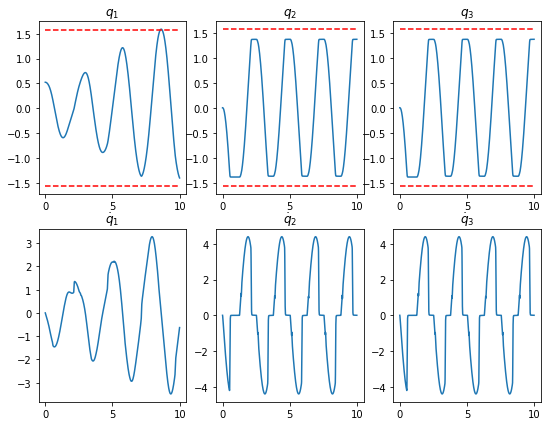

succeed


In [231]:
fig = swing_plot(t, sol)
plt.show(fig)
if np.max(np.abs(sol[:, 0])) > np.pi / 2:
    print('succeed')
else:
    print('fail')

In [223]:
anim = swing_animation(sol, param0)
HTML(anim.to_html5_video())

In [140]:
def open_loop_test(amp, omega, phi):
    amp = np.array([1, 1]) * 2 * np.pi *amp 
    omega = np.array([1, 1]) * 10 * omega
    phi = np.array([np.pi*2, np.pi*2]) * phi
    fv = fv_gen(amp, omega, phi, q_max)
    t0 = 0
    t1 = 10
    dt = 0.01
    t = np.arange(t0, t1, dt)
    q0 = np.array([np.pi/6, 0, 0])
    a0 = np.array([0, 0])
    v0 = fv(t0, np.r_[q0, np.zeros(3)])
    y0 = np.r_[q0, 0, v0]
    ddq_np(y0, a0, param0, con0)
    sol = odeint(f, y0, t, args=(param0, con0, a_max, dt))
    return sol

# Utils

In [146]:
def kinematics(y, param):
    p1_ = p1_np(y ,param).squeeze()
    p2_ = p2_np(y, param).squeeze()
    p3_ = p3_np(y, param).squeeze()
    p21_= p21_np(y, param).squeeze()
    p31_= p31_np(y, param).squeeze()
    return (p1_, p2_, p3_, p21_, p31_)

In [40]:
def swing_plot(t, sol):
    fig, axes = plt.subplots(2, 3, figsize=(9, 7))
    axes = axes.ravel()
    for i, ax in enumerate(axes):
        ax.plot(t, sol[:, i])
        if i < 3:
            ax.plot([t[0], t[-1]], [ np.pi/2, np.pi/2], 'r--')
            ax.plot([t[0], t[-1]], [-np.pi/2,-np.pi/2], 'r--')
            ax.set_title('$q_{}$'.format(i+1))
        else:
            ax.set_title('$\dot{q}_' + '{}$'.format(i-2))
    return fig


In [145]:
def swing_animation(sol, param0):
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.axis('equal')
    plt.axis([-3, 3, -3, 3])

    line1, = ax.plot([], [], lw=1, color='k', linestyle='-', marker='o', ms=5)
    line2, = ax.plot([], [], lw=2, color='b', linestyle='-', marker='o', ms=3)

    def init():
        line1.set_data([], [])
        line2.set_data([], [])
        return (line1, line2)

    def animate(i):
        y = sol[i, :]
        p1, p2, p3, p21, p31 = kinematic(sol[i, :], param0)
        line1.set_data([0, p1[0]], [0, p1[1]])
        line2.set_data([p21[0], p2[0], p3[0], p31[0]], [p21[1], p2[1], p3[1], p31[1]])
        return (line1,line2)
    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=1000, interval=10, blit=True)
    return anim

# Serialization

In [153]:
cloudpickle.dump(f, open('swing_dynamic.dll', 'wb'))
cloudpickle.dump(f_open_loop, open('swing_open_loop_dynamic.dll', 'wb'))
cloudpickle.dump(kinematics, open('swing_kinematic.dll', 'wb'))

In [232]:
from collections import namedtuple

In [234]:
Solution = namedtuple('Solution', ['t', 'response', 'parameters'])

In [244]:
sol1 = Solution(t, sol, param0)

In [246]:
cloudpickle.dump(sol1, open('./sol_eg.pkl', 'wb'))